## Load dependencies

In [34]:
# --- standard ---
import os
import sys
import time
from datetime import datetime
from pathlib import Path

# --- scientific ---
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LightSource
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.interpolate import RBFInterpolator
from scipy.spatial import cKDTree

# --- machine learning / preprocessing ---
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering

# --- geostatistics ---
import skgstat as skg
from skgstat import models
import gstatsim as gs

# --- image / geometry utilities ---
from skimage.measure import find_contours
import pygmt
from scipy.ndimage import map_coordinates

# --- parallelization ---
from joblib import Parallel, delayed

# --- local utilities (custom colormap) ---
from multigrid_sgsim.utils import geosoft_cmap_k65
geosoft_cmap = geosoft_cmap_k65()
ls = LightSource(azdeg=120, altdeg=45)

# --- local multigrid SGSIM implementation ---
from multigrid_sgsim import mgsim, sampling, trendmaking
from multigrid_sgsim.utils import cluster_variogram
from multigrid_sgsim.asm import asm_energy, asm_cluster


## Load and plot the (1) ground truth data and (2) the flightlines

In [15]:
## =================================================== ##
## LOAD AND PLOT THE GROUND TRUTH DATA AND FLIGHTLINES ##
## =================================================== ##

## GROUND TRUTH 
rows = 50
cols = 200
df_gt_xyvc = pd.read_csv("./data/gt_xyvc.csv")
gt_xyv = df_gt_xyvc.values
synthmag_gt = gt_xyv[:,2].reshape(rows, cols)

# FLIGHTLINES
df_fl_xyvc = pd.read_csv("./data/fl_xyvc.csv")
fl_xyvc = df_fl_xyvc.values



## Minimum curvature of flightlines to get raster on which we can run ASM

In [16]:
## PERFORM MINIMUM CURVATURE GRIDDING ##
## ================================== ##

x = fl_xyvc[:,0]
y = fl_xyvc[:,1]
z = fl_xyvc[:,2]

region = [x.min(), x.max(), y.min(), y.max()]
spacing = 1

# Pre-thinning
tbl = pygmt.blockmedian(x=x, y=y, z=z, region=region, spacing=spacing)

# Minimum curvature
grid_mc = pygmt.surface(x=x, y=y, z=z, region=region, spacing=spacing, tension=0)





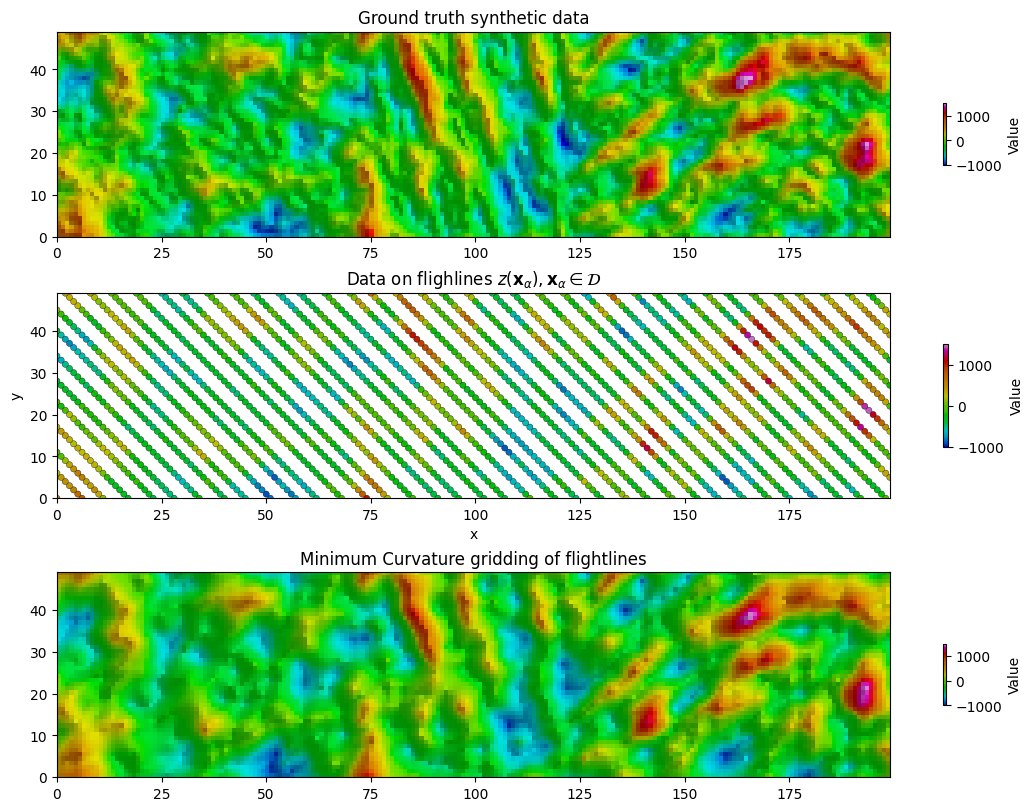

In [20]:
## PLOT MIN CURVATURE GRID ##
## ======================= ##

# --- extents ---
xmin, xmax = float(grid_mc.x.min()), float(grid_mc.x.max())
ymin, ymax = float(grid_mc.y.min()), float(grid_mc.y.max())
extent = [xmin, xmax, ymin, ymax]

# --- light shading ---
vmin = -1000
vmax=1500
rgb_s2   = ls.shade(synthmag_gt, cmap=geosoft_cmap, blend_mode='soft', vmin=vmin, vmax=vmax)
rgb_grid = ls.shade(grid_mc.values,       cmap=geosoft_cmap, blend_mode='soft', vmin=vmin,    vmax=vmax)
norm = Normalize(vmin=vmin, vmax=vmax)

# --- mappables for colorbars ---
mappable_s2   = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=geosoft_cmap)
mappable_grid = ScalarMappable(norm=Normalize(vmin=vmin,    vmax=vmax),    cmap=geosoft_cmap)

# --- light shading ---
vmin = -1000
vmax=1500
rgb_s2   = ls.shade(synthmag_gt, cmap=geosoft_cmap, blend_mode='soft', vmin=vmin, vmax=vmax)


# -- plotting --
fig, axs = plt.subplots(3, 1, figsize=(12, 8), constrained_layout=True)
# Original smoothed data
axs[0].imshow(rgb_s2, origin='lower', extent=extent)
# axs[0].scatter(x, y, c='k', s=20, alpha=0.2, linewidths=0, rasterized=True)
axs[0].set_xlim(xmin, xmax); axs[0].set_ylim(ymin, ymax)
axs[0].set_title(f"Ground truth synthetic data")
fig.colorbar(mappable_s2, ax=axs[0], shrink=0.3, label="Value")

# flight line data:
fl_x, fl_y, fl_val = fl_xyvc[:, 0], fl_xyvc[:, 1], fl_xyvc[:, 2]
sc = axs[1].scatter(fl_x, fl_y,c=fl_val, cmap=geosoft_cmap, norm=norm,s=20, edgecolors='k', linewidths=0.25,rasterized=True)
axs[1].set_title(r'Data on flighlines $z(\mathbf{x}_\alpha), \mathbf{x}_\alpha\in\mathcal{D}$')
axs[1].set_xlabel("x"); axs[1].set_ylabel("y")
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlim(extent[0], extent[1])
axs[1].set_ylim(extent[2], extent[3])
sm = plt.cm.ScalarMappable(norm=norm, cmap=geosoft_cmap)
sm.set_array([])
fig.colorbar(sm, ax=axs[1], shrink=0.5, label='Value')

# Minimum curvature grid
axs[2].imshow(rgb_grid, origin='lower', extent=extent)
# axs[1].scatter(x, y, c='k', s=20, alpha=0.2, linewidths=0, rasterized=True)
axs[2].set_xlim(xmin, xmax); axs[1].set_ylim(ymin, ymax)
axs[2].set_title(f"Minimum Curvature gridding of flightlines")
fig.colorbar(mappable_grid, ax=axs[2], shrink=0.3, label="Value")


plt.show()


## Run ASM on both (1) minimum curvature raster and (2) groundtruth

In [22]:
## USE THE asm_energy() FUNCTION TO BUILD ENERGY IMAGES ##
## ==================================================== ##

freqs = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5])
grid_in_mc = grid_mc.values
grid_in_gt = synthmag_gt

filtered_stack_mc = asm_energy(grid_in_mc, freqs, 8)
filtered_stack_gt = asm_energy(grid_in_gt, freqs, 8)


Processed Gabor θ=0.0°, f=0.010
Processed Gabor θ=22.5°, f=0.010
Processed Gabor θ=45.0°, f=0.010
Processed Gabor θ=67.5°, f=0.010
Processed Gabor θ=90.0°, f=0.010
Processed Gabor θ=112.5°, f=0.010
Processed Gabor θ=135.0°, f=0.010
Processed Gabor θ=157.5°, f=0.010
Processed Gabor θ=0.0°, f=0.050
Processed Gabor θ=22.5°, f=0.050
Processed Gabor θ=45.0°, f=0.050
Processed Gabor θ=67.5°, f=0.050
Processed Gabor θ=90.0°, f=0.050
Processed Gabor θ=112.5°, f=0.050
Processed Gabor θ=135.0°, f=0.050
Processed Gabor θ=157.5°, f=0.050
Processed Gabor θ=0.0°, f=0.100
Processed Gabor θ=22.5°, f=0.100
Processed Gabor θ=45.0°, f=0.100
Processed Gabor θ=67.5°, f=0.100
Processed Gabor θ=90.0°, f=0.100
Processed Gabor θ=112.5°, f=0.100
Processed Gabor θ=135.0°, f=0.100
Processed Gabor θ=157.5°, f=0.100
Processed Gabor θ=0.0°, f=0.150
Processed Gabor θ=22.5°, f=0.150
Processed Gabor θ=45.0°, f=0.150
Processed Gabor θ=67.5°, f=0.150
Processed Gabor θ=90.0°, f=0.150
Processed Gabor θ=112.5°, f=0.150
Proc

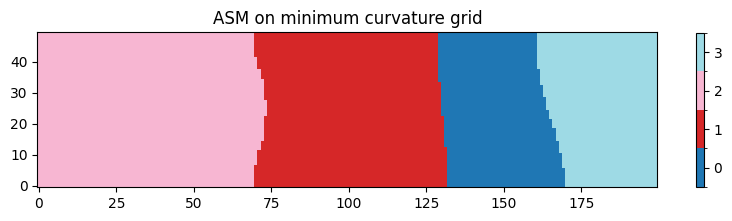

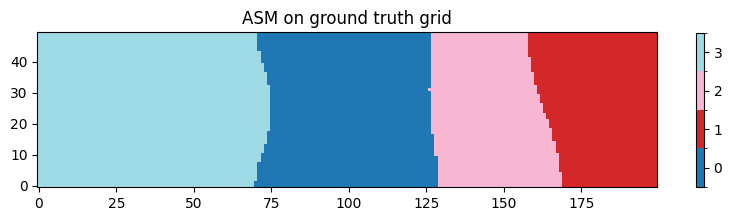

In [33]:
## PERFORM CLUSTERING WITH asm_cluster() ##
## ===================================== ##

k = 4
spatial_weight = 1
segmentation_mc = asm_cluster(filtered_stack_mc, k, spatial_weight)
segmentation_gt = asm_cluster(filtered_stack_gt, k, spatial_weight)

# assume segmentation_mc is an array of integer cluster IDs
n_clusters = int(segmentation_mc.max() + 1)  # number of unique clusters

# make a ListedColormap with as many colors as clusters
# New API: colormap lookup + resampling
cmap = plt.colormaps["tab20"].resampled(n_clusters)

# norm ensures discrete mapping (0..n_clusters-1)
norm = mcolors.BoundaryNorm(
    boundaries=np.arange(-0.5, n_clusters+0.5, 1),
    ncolors=n_clusters
)

plt.figure(figsize=(10,5))
im = plt.imshow(segmentation_mc, origin="lower", cmap=cmap, norm=norm)
plt.title(f"ASM on minimum curvature grid")
plt.colorbar(im, shrink=0.4, ticks=np.arange(n_clusters))

plt.figure(figsize=(10,5))
im2 = plt.imshow(segmentation_gt, origin="lower", cmap=cmap, norm=norm)
plt.title(f"ASM on ground truth grid")
plt.colorbar(im2, shrink=0.4, ticks=np.arange(n_clusters))
plt.show()


In [ ]:
## ADD REGION TO GROUND TRUTH ARRAY ##
## ================================ ##

seg_mc_flat = segmentation_mc.ravel()
seg_col = seg_mc_flat[:, None]
gt_xyvc = np.concatenate([gt_xyv, seg_col], axis=1)

# save
np.savetxt(
    "/Users/jrines/stanford_gp/research/mx/computers_geosciences/data/gt_xyvc.csv",
    gt_xyvc,
    delimiter=",",
    fmt="%.6f",  # 6 decimals for floats
    header="x,y,val,clust",
    comments=""   # prevents '#' in header
)

# plot
plt.figure(figsize=(15,3))
plt.scatter(gt_xyvc[:,0], gt_xyvc[:,1], c=gt_xyvc[:,3], cmap=cmap, norm=norm)
plt.title(f"Regions added to gt_xyvc")
plt.colorbar(shrink=0.6, ticks=np.arange(n_clusters))


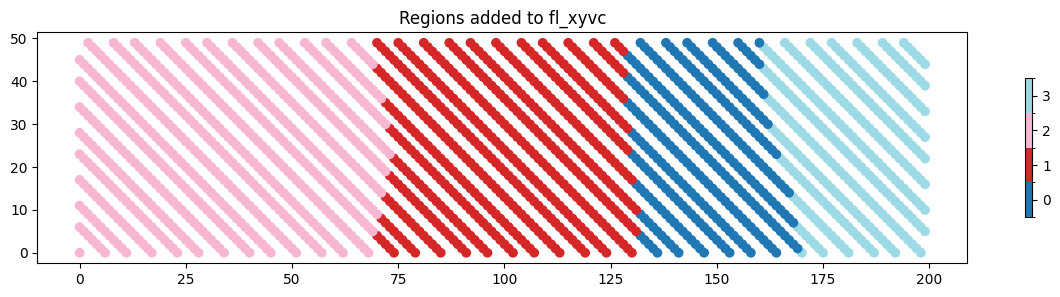

In [38]:
## ADD REGION TO FLIGHT LINES ARRAY ##
## ================================ ##

df_fl_xyvc = pd.read_csv("./data/fl_xyvc.csv")
fl_xyv = df_fl_xyvc.values[:,:3]

coords = np.vstack([fl_xyv[:,1], fl_xyv[:,0]]) # (y, x)
region_ids = map_coordinates(segmentation_mc, coords, order=0, mode="nearest")
fl_xyvc = np.column_stack([fl_xyv, region_ids])

# save
np.savetxt(
    "./data/fl_xyvc.csv",
    fl_xyvc,
    delimiter=",",
    fmt="%.6f",  # 6 decimals for floats
    header="x,y,val,clust",
    comments=""   # prevents '#' in header
)

# plot
plt.figure(figsize=(15,3))
plt.scatter(fl_xyvc[:,0], fl_xyvc[:,1], c=fl_xyvc[:,3], cmap=cmap, norm=norm)
plt.title(f"Regions added to fl_xyvc")
plt.colorbar(shrink=0.6, ticks=np.arange(n_clusters))